# Classification Models


In this notebook we will be building classification models on preprocessed data.

In [ ]:
import os
import copy
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import warnings

from CogniPredictAD.classification import ADNIClassifier
from CogniPredictAD.visualization import Visualizer
from imblearn.pipeline import Pipeline
from sklearn.tree import export_text, export_graphviz, plot_tree

pd.set_option("display.max_rows", 116)
pd.set_option("display.max_columns", 40)
pd.set_option("display.max_info_columns", 40) 

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(
    "ignore",
    message=".*The `disp` and `iprint` options of the L-BFGS-B solver are deprecated.*",
    category=DeprecationWarning
)

train = pd.read_csv("../data/train.csv")
sampled = pd.read_csv("../data/sampled.csv")

display(train)

,DX,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,CDRSB,ADAS13,LDELTOTAL,FAQ,MOCA,TRABSCOR,RAVLT_immediate,RAVLT_learning,RAVLT_perc_forgetting,mPACCdigit,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,FDG,TAU/ABETA,PTAU/ABETA,Hippocampus/ICV,Entorhinal/ICV,Fusiform/ICV,MidTemp/ICV,Ventricles/ICV,WholeBrain/ICV
0,AD,80,1,14,0,21,6.5,42,0,19,13,300,15,1,100.0000,-20.06920,3.14286,3.000000,3.000000,3.200000,2.500000,2.75,4.000000,3.444440,2.666670,3.000000,3.666670,3.75,1.042620,0.630939,0.061115,0.003517,0.000970,0.009514,0.011188,0.039862,0.680575
1,LMCI,82,1,20,0,24,1.5,20,2,4,20,155,29,0,83.3333,-10.20060,2.10000,1.780554,1.274284,1.373334,1.699998,1.65,2.950000,2.530556,2.014286,1.756666,2.316666,2.75,1.080580,0.421770,0.041719,0.003360,0.001276,0.008863,0.010643,0.049299,0.640478
2,LMCI,71,1,19,0,26,1.0,8,2,2,25,106,51,2,-18.1818,-5.90200,2.75000,2.555560,2.285710,3.200000,3.833330,3.50,1.510714,1.266666,1.438096,1.760000,1.680000,1.85,1.414550,0.182691,0.016757,0.005090,0.002786,0.012161,0.014206,0.025251,0.630110
3,CN,75,0,20,0,30,0.0,6,19,0,26,58,61,7,20.0000,3.19941,1.75000,1.333330,1.000000,1.000000,1.166670,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.118820,0.263255,0.024724,0.004908,0.002758,0.012983,0.013293,0.044823,0.677111
4,CN,81,0,19,0,29,0.0,8,11,0,29,54,54,7,28.5714,-1.16303,1.87500,1.555560,1.000000,1.000000,1.333330,1.75,1.375000,1.111110,1.000000,1.200000,1.166670,1.75,1.270141,0.197315,0.018091,0.004700,0.002912,0.013675,0.016983,0.036393,0.726675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,LMCI,64,0,14,2,27,2.0,22,0,9,22,62,31,1,100.0000,-10.37820,2.97500,1.930556,1.585714,1.400000,1.416668,1.95,3.025000,1.955554,1.671428,1.600000,1.866666,2.35,1.096238,0.709354,0.067789,0.003776,0.001849,0.010658,0.011583,0.019025,0.659038
1930,LMCI,82,1,18,0,28,1.5,23,5,1,25,79,33,1,42.8571,-9.18102,2.12500,1.125000,1.166670,2.000000,2.500000,2.00,2.625000,1.625000,1.166670,1.400000,1.833330,2.00,1.068610,0.263624,0.025132,0.003199,0.001527,0.012497,0.014003,0.030409,0.648833
1931,LMCI,76,1,12,0,25,1.0,16,3,1,22,300,27,2,16.6667,-9.94141,1.60000,1.533332,1.219048,1.040000,1.133334,1.45,2.100000,1.322222,1.657144,1.400000,1.366666,2.05,1.130734,0.175266,0.015387,0.005291,0.002843,0.009460,0.013091,0.019144,0.634472
1932,LMCI,74,1,19,1,26,2.0,27,3,8,21,102,32,1,100.0000,-13.05080,1.87500,1.333330,1.000000,1.200000,1.333330,1.00,3.125000,2.875000,1.857140,1.333330,2.250000,3.25,1.116780,0.673073,0.062445,0.002890,0.001061,0.008794,0.009382,0.040972,0.642200


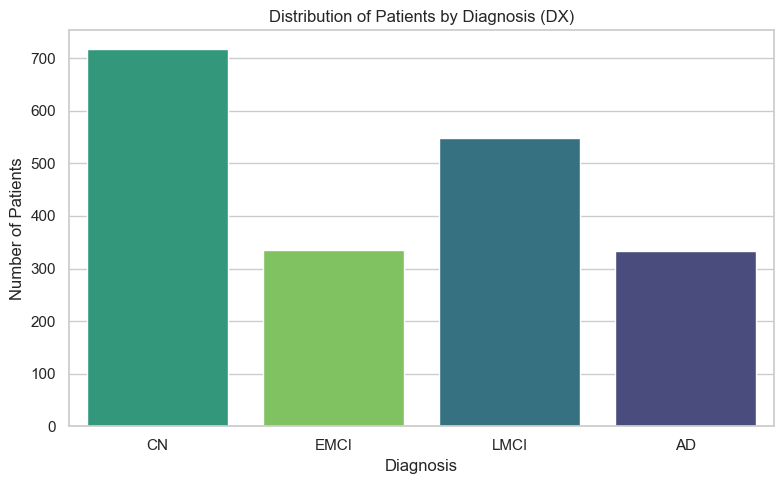

In [2]:
viz = Visualizer(train)
viz.count_plot(
    x="DX",
    figsize=(8, 5),
    palette="viridis",
    order = ["CN", "EMCI", "LMCI", "AD"],
    xlabel="Diagnosis",
    ylabel="Number of Patients",
    title="Distribution of Patients by Diagnosis (DX)"
)

We already see that: 
- CN:   717 -> 37.07%
- EMCI: 336 -> 17.37%
- LMCI: 548 -> 28.34%
- AD:   333 -> 17.22%

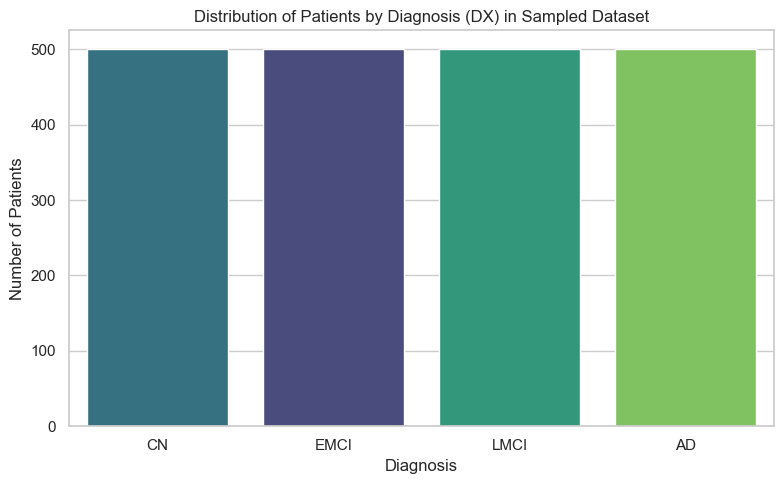

In [3]:
viz = Visualizer(sampled)
viz.count_plot(
    x="DX",
    figsize=(8, 5),
    palette="viridis",
    order = ["CN", "EMCI", "LMCI", "AD"],
    xlabel="Diagnosis",
    ylabel="Number of Patients",
    title="Distribution of Patients by Diagnosis (DX) in Sampled Dataset"
)

In [4]:
pretrain = pd.read_csv("../data/pretrain.csv")

# Target column
y_train = pretrain['DX']

# All other columns as features
X_train = pretrain.drop(columns=['DX'])

The **ADNIClassifier** class was designed as a support tool for training and evaluating different classification models on data derived from the ADNI dataset. Upon initialization, it allows you to choose between different sets of classifiers, which can be traditional models or explainable methods (XAI), already configured with the best hyperparameters found via grid search. The main function, `fit_evaluate_store_models`, takes the training data and, for each classifier, performs a repeated stratified cross-validation (5-fold by default), collects predictions and probabilities, calculates global and class-specific metrics, generates comparison plots and confusion matrices. Finally, it refits each model on the entire training set, saves it to disk, and returns two DataFrames: one with the overall metrics and one with the results by class.

## Explainability Function for Decision Tree

In [ ]:
def save_xai_models(X_train, models_dir="../results/all_models"):
    """
    Load Decision Tree models from `models_dir` (even if inside Pipelines)
    and save XAI outputs (rules and tree images) as TXT and PDF.
    Only models whose filenames start with "Decision_Tree" are processed.
    """
    try:
        trees_dir = os.path.join(models_dir, "trees")
        rules_dir = os.path.join(models_dir, "rules")
        os.makedirs(trees_dir, exist_ok=True)
        os.makedirs(rules_dir, exist_ok=True)

        feature_names = list(X_train.columns) if hasattr(X_train, "columns") else [f"f{i}" for i in range(X_train.shape[1])]

        if not os.path.isdir(models_dir):
            raise FileNotFoundError(f"models_dir not found: {models_dir}")

        models = []
        for fname in os.listdir(models_dir):
            if fname.endswith(".pkl") and fname.startswith("Decision_Tree"):
                with open(os.path.join(models_dir, fname), "rb") as f:
                    model = pickle.load(f)
                models.append((os.path.splitext(fname)[0], model))
        print(f"Found {len(models)} Decision_Tree models:", [n for n, _ in models])

        desired_order = ["CN", "EMCI", "LMCI", "AD"] # from least to most severe

        for model_name, model in models:
            tree_model = None
            if isinstance(model, Pipeline):
                tree_model = model.named_steps.get('clf', None) or next(
                    (s for s in model.named_steps.values() if hasattr(s, "tree_")), None
                )
                tree_model = tree_model or model
            else:
                tree_model = model

            if not hasattr(tree_model, "tree_"):
                raise ValueError(f"{model_name} is not a DecisionTree model.")

            orig_classes = list(getattr(tree_model, "classes_", []))
            display_classes = [c for c in desired_order if c in orig_classes] + [c for c in orig_classes if c not in desired_order]
            idx_map = [orig_classes.index(c) for c in display_classes]

            tree_copy = copy.deepcopy(tree_model)

            # Reorder values along class axis
            try:
                tree_copy.tree_.value[:] = tree_copy.tree_.value[:, :, idx_map]
            except Exception:
                pass
            tree_copy.classes_ = np.array(display_classes)
            tree_copy.n_classes_ = len(display_classes)

            # --- Adjust leaf nodes to pick worst class if tied ---
            for i in range(tree_copy.tree_.node_count):
                if tree_copy.tree_.children_left[i] == tree_copy.tree_.children_right[i] == -1:  # leaf node
                    vals = tree_copy.tree_.value[i, 0]  # shape: (n_classes,)
                    max_val = vals.max()
                    tied_classes = [display_classes[j] for j, v in enumerate(vals) if v == max_val]
                    if len(tied_classes) > 1:
                        # pick the class with highest severity
                        worst_class = max(tied_classes, key=lambda c: desired_order.index(c))
                        tree_copy.tree_.value[i, 0, :] = 0
                        tree_copy.tree_.value[i, 0, display_classes.index(worst_class)] = max_val

            # --- Export textual rules ---
            rules_text = export_text(tree_copy, feature_names=feature_names)
            rules_text_ifthen = []
            for line in rules_text.splitlines():
                stripped = line.lstrip()
                indent = (len(line) - len(stripped)) // 4
                if stripped.startswith("|---"):
                    rules_text_ifthen.append("    " * indent + "IF " + stripped.replace("|---", "").strip())
                else:
                    rules_text_ifthen.append("    " * indent + stripped.replace("class:", "THEN class ="))
            rules_text = "\n".join(rules_text_ifthen)

            with open(os.path.join(rules_dir, f"{model_name}_rules.txt"), "w", encoding="utf-8") as f:
                f.write(rules_text)

            # --- Export tree diagram ---
            class_names = [str(c) for c in getattr(tree_copy, "classes_", [])] or None
            try:
                dot_data = export_graphviz(
                    tree_copy, out_file=None, feature_names=feature_names,
                    class_names=class_names, filled=True, rounded=True,
                    special_characters=True, label='all'
                )
                graph = graphviz.Source(dot_data)
                graph.render(os.path.join(trees_dir, f"{model_name}_tree"), format="pdf", cleanup=True)
            except Exception:
                fig, ax = plt.subplots(figsize=(16, 12))
                plot_tree(tree_copy, feature_names=feature_names, class_names=class_names,
                          filled=True, rounded=True, ax=ax, label='all')
                fig.savefig(os.path.join(trees_dir, f"{model_name}_tree.pdf"), bbox_inches="tight", dpi=600)
                plt.close(fig)

        print("XAI outputs saved.")

    except Exception as e:
        print(f"Error in save_xai_models: {e}")


## Model Creation

Training & Evaluating: Decision Tree
Training & Evaluating: Random Forest
Training & Evaluating: Extra Trees
Training & Evaluating: Adaptive Boosting
Training & Evaluating: Multinomial Logistic Regression
Training & Evaluating: Decision Tree Sampled
Training & Evaluating: Random Forest Sampled
Training & Evaluating: Extra Trees Sampled
Training & Evaluating: Adaptive Boosting Sampled
Training & Evaluating: Multinomial Logistic Regression Sampled


,Model,F1 Score (macro),Accuracy,Balanced Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),ROC AUC (macro)
3,Adaptive Boosting,0.911786,0.922268,0.915558,0.923269,0.922268,0.922544,0.986003
1,Random Forest,0.910172,0.921234,0.913116,0.922126,0.921234,0.921348,0.985127
8,Adaptive Boosting Sampled,0.909071,0.919511,0.913006,0.920669,0.919511,0.919840,0.985740
2,Extra Trees,0.908775,0.919511,0.911227,0.920504,0.919511,0.919728,0.986551
6,Random Forest Sampled,0.907470,0.918304,0.912140,0.919918,0.918304,0.918580,0.985004
7,Extra Trees Sampled,0.902992,0.913478,0.907954,0.915489,0.913478,0.914014,0.986862
0,Decision Tree,0.898010,0.910893,0.903001,0.912230,0.910893,0.911214,0.978340
5,Decision Tree Sampled,0.892173,0.906584,0.892866,0.907672,0.906584,0.906422,0.975305
9,Multinomial Logistic Regression Sampled,0.866901,0.881420,0.873604,0.884341,0.881420,0.882005,0.977881
4,Multinomial Logistic Regression,0.866272,0.880903,0.873613,0.884131,0.880903,0.881412,0.979217


,Model,Class,Precision,Recall,F1 Score,Support
0,Decision Tree,CN,0.984286,0.960948,0.972477,2151.0
1,Decision Tree,EMCI,0.883764,0.950397,0.915870,1008.0
2,Decision Tree,LMCI,0.897677,0.869830,0.883534,1644.0
3,Decision Tree,AD,0.809756,0.830831,0.820158,999.0
4,Random Forest,CN,0.981384,0.955834,0.968441,2151.0
5,Random Forest,EMCI,0.878565,0.947421,0.911695,1008.0
6,Random Forest,LMCI,0.903869,0.909367,0.906610,1644.0
7,Random Forest,AD,0.868530,0.839840,0.853944,999.0
8,Extra Trees,CN,0.984652,0.954440,0.969311,2151.0
9,Extra Trees,EMCI,0.886810,0.940476,0.912855,1008.0


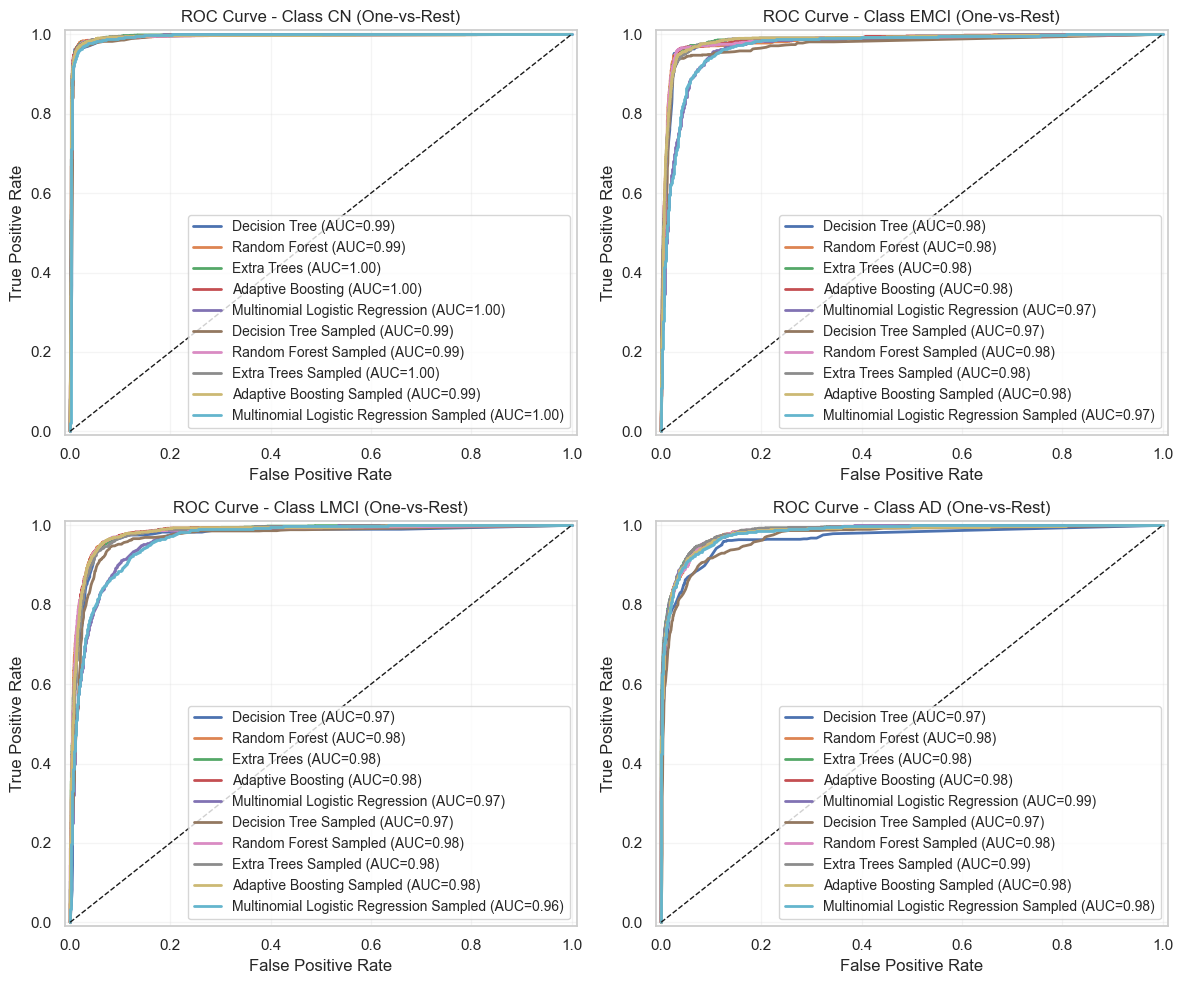

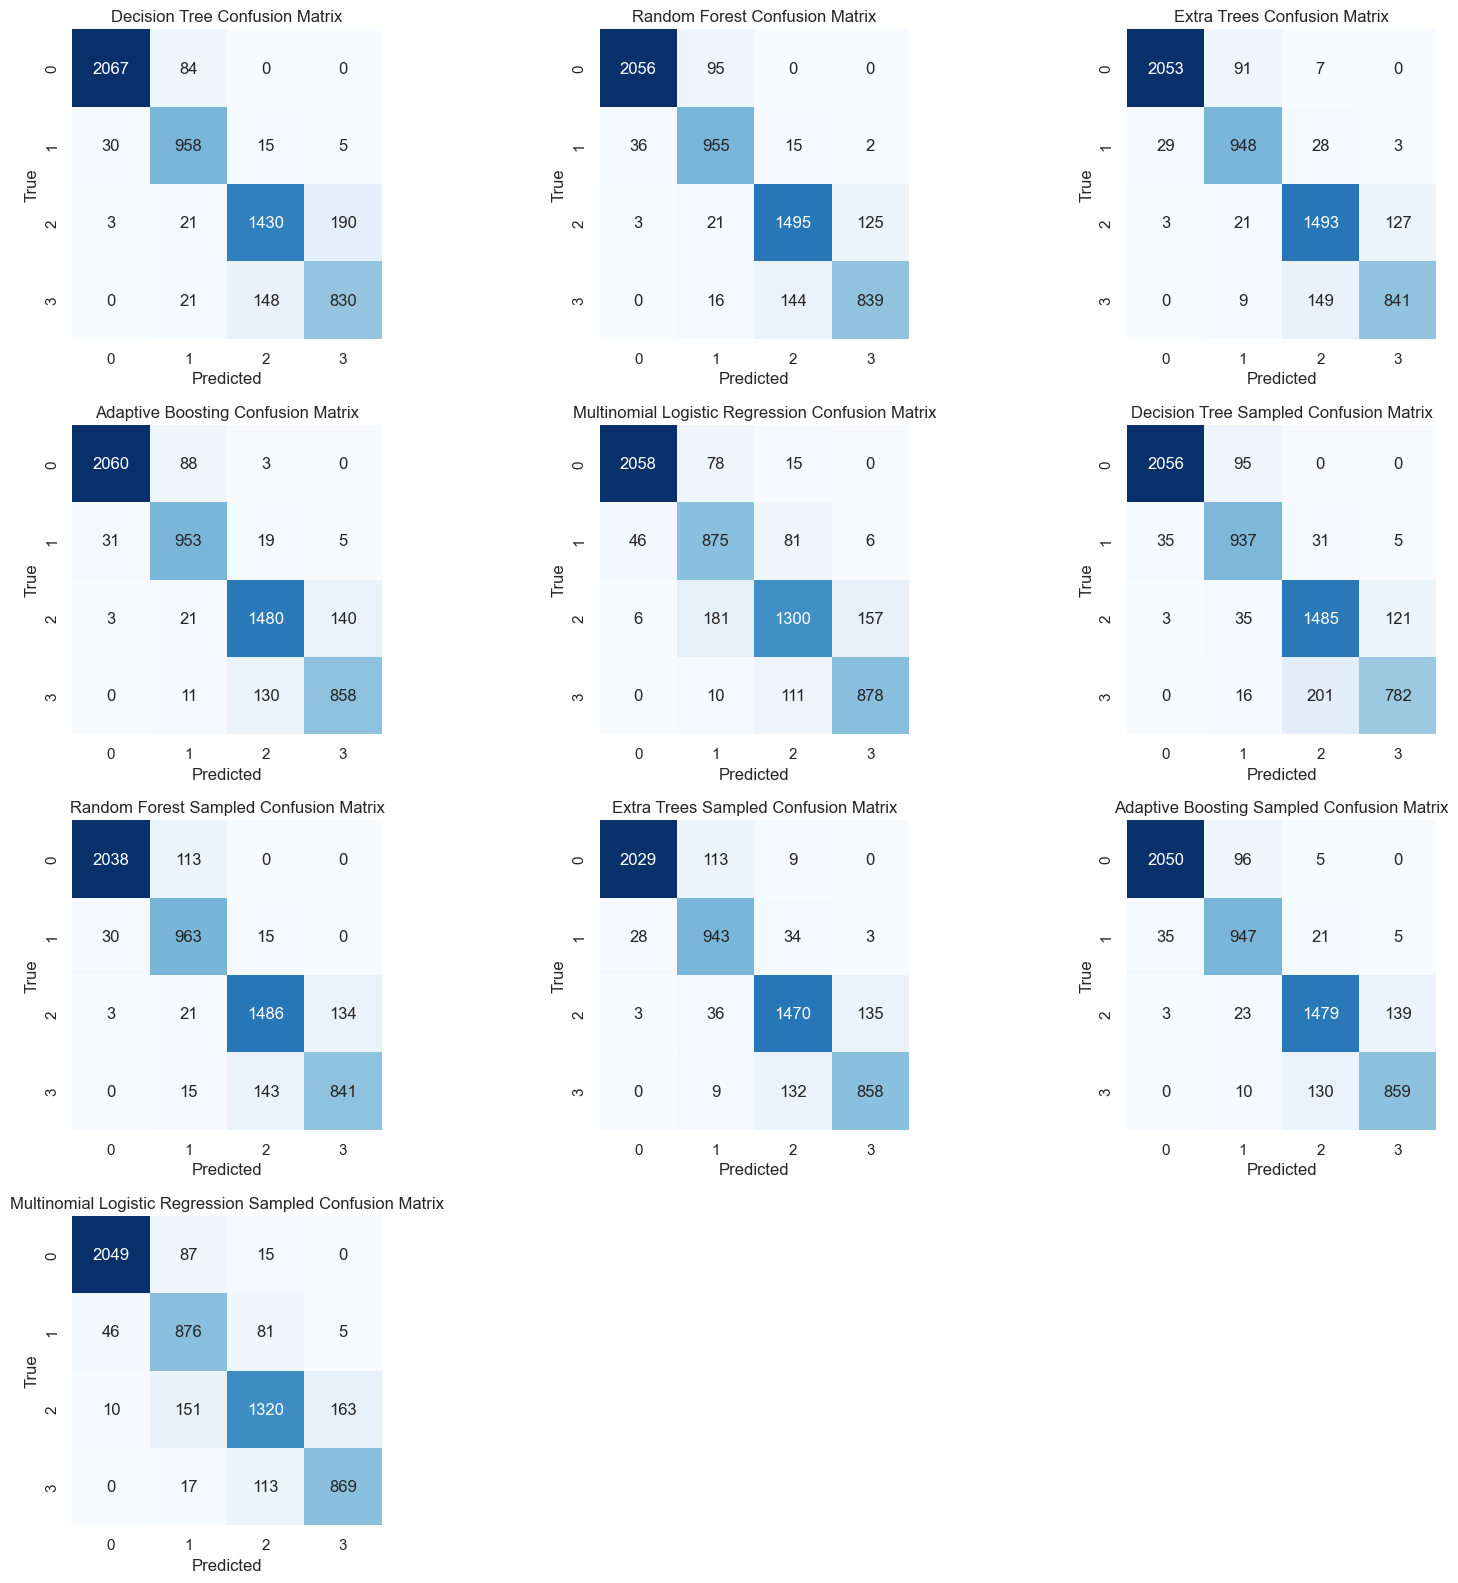

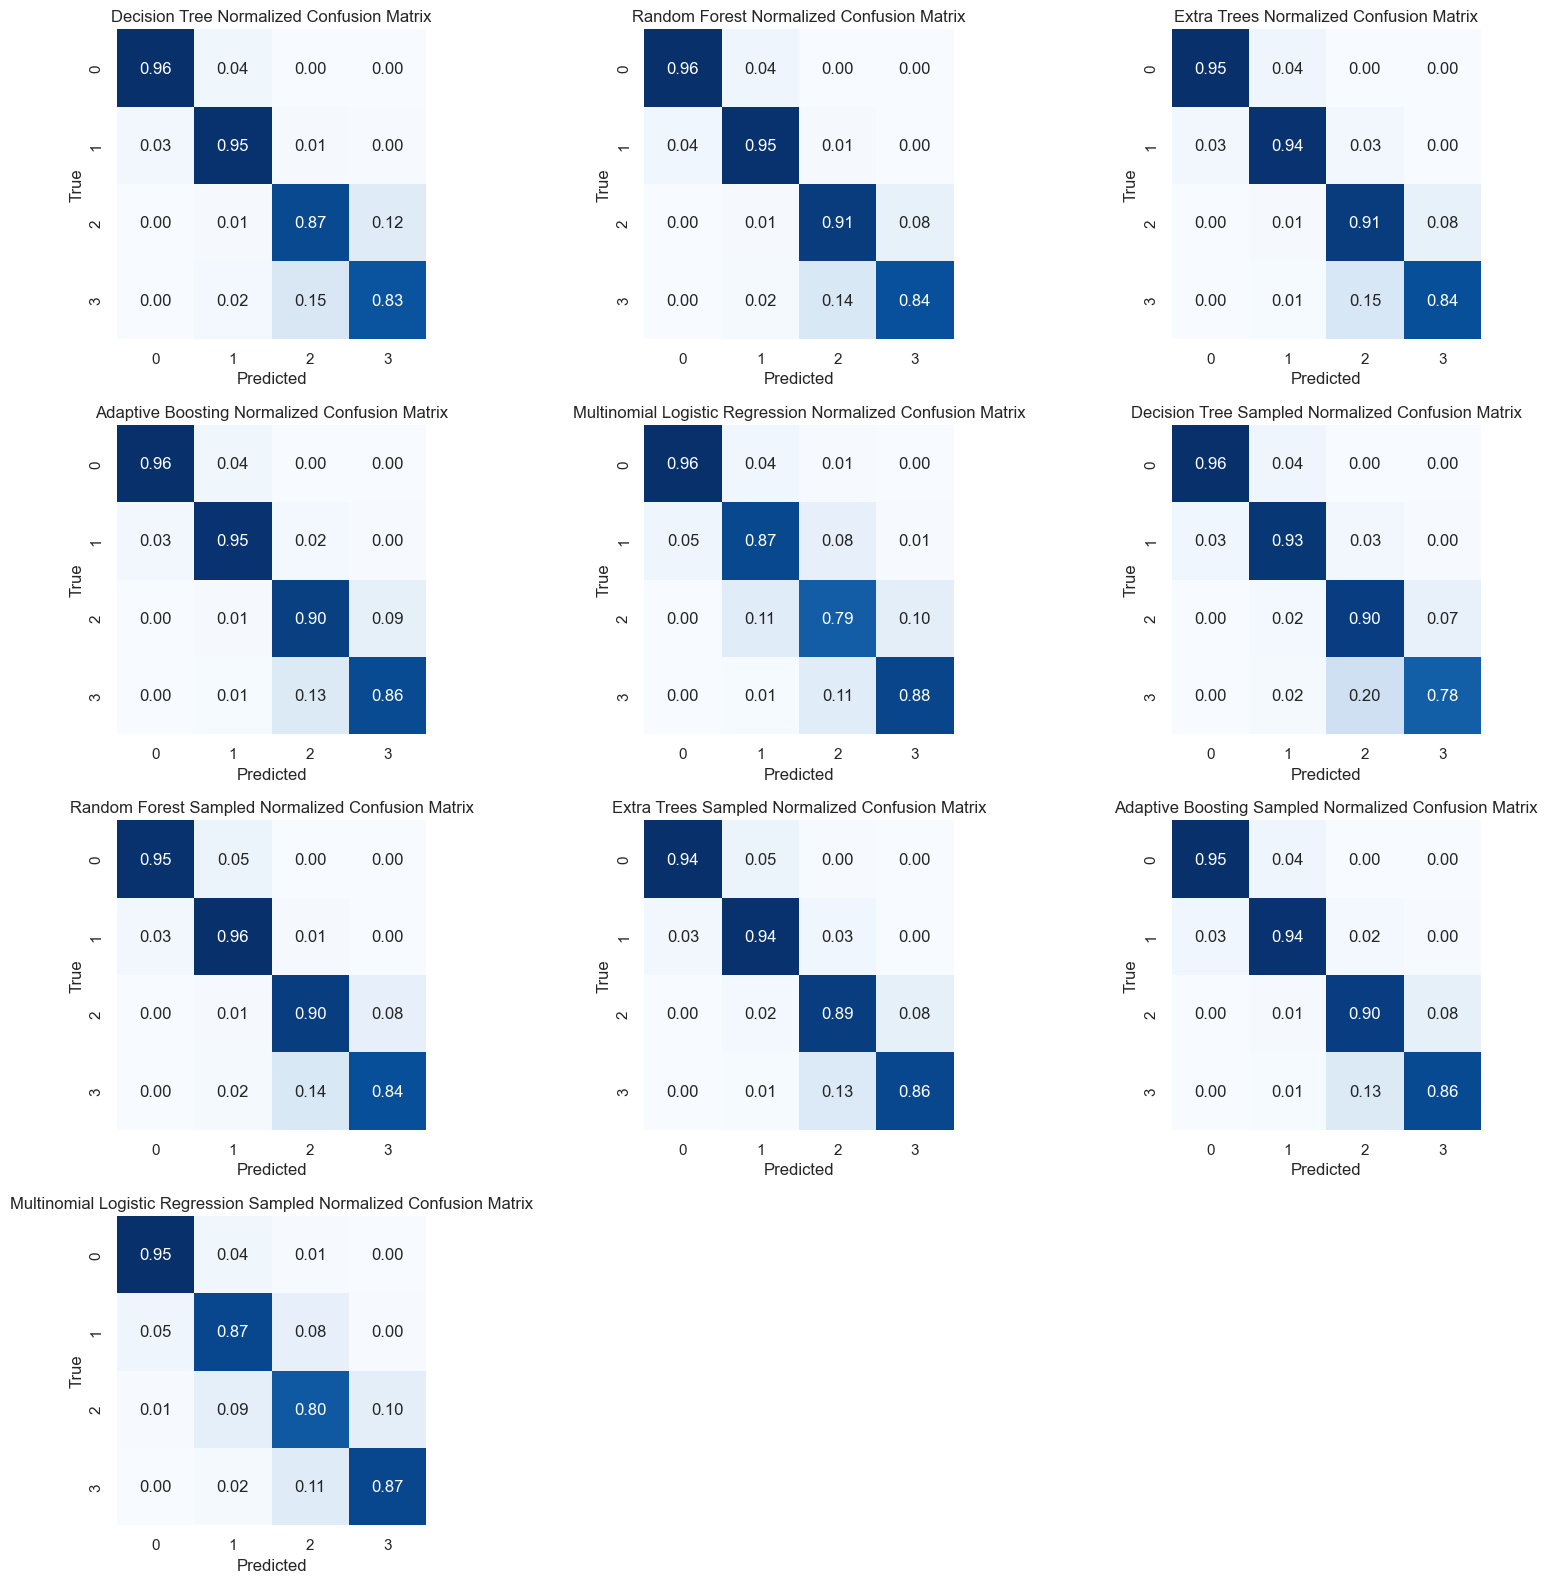

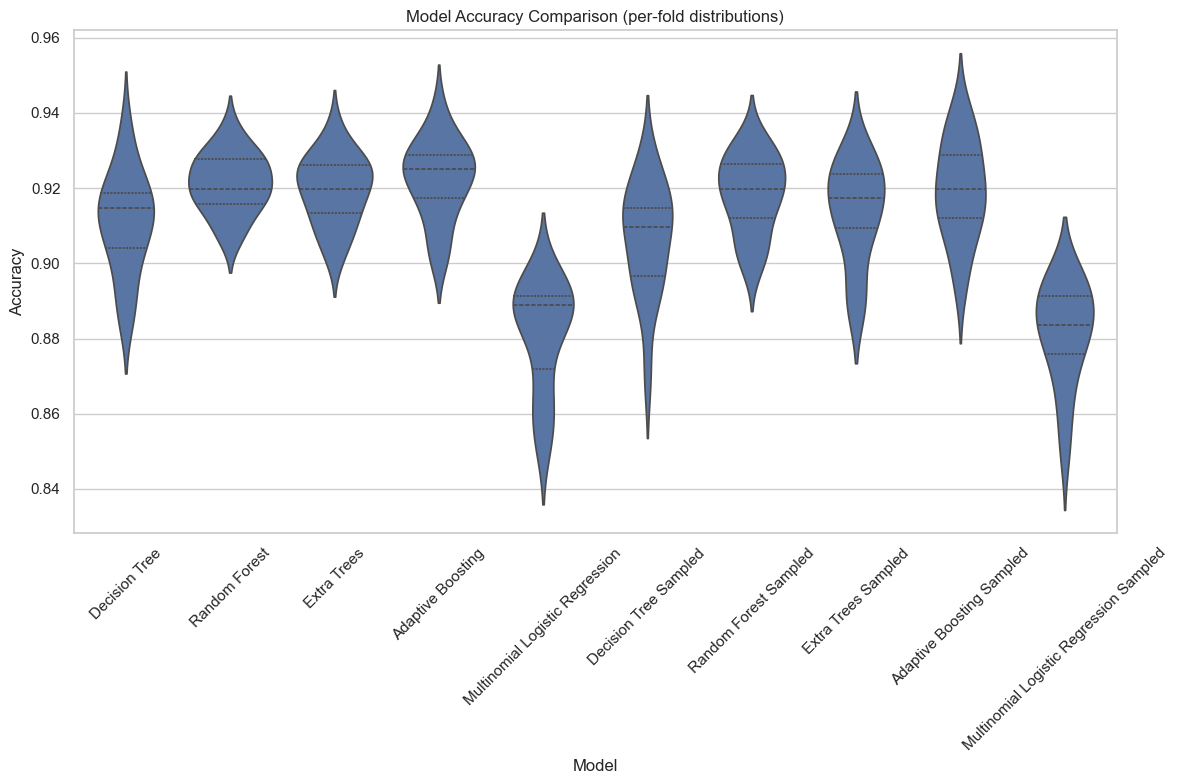

,Model A,Model B,Statistic,P-value
0,Adaptive Boosting,Adaptive Boosting Sampled,8.0,0.001526
1,Adaptive Boosting,Multinomial Logistic Regression Sampled,11.0,0.003357
2,Random Forest,Adaptive Boosting,13.0,0.005371
3,Adaptive Boosting,Multinomial Logistic Regression,13.0,0.005371
4,Adaptive Boosting,Random Forest Sampled,17.0,0.012451
5,Random Forest,Decision Tree Sampled,18.0,0.015076
6,Multinomial Logistic Regression,Decision Tree Sampled,18.0,0.015076
7,Decision Tree Sampled,Random Forest Sampled,21.0,0.025574
8,Adaptive Boosting,Extra Trees Sampled,22.0,0.030151
9,Decision Tree,Random Forest,24.0,0.041260


In [6]:
classifier = ADNIClassifier(classifier="Standard")
res = classifier.fit_evaluate_store_models(X_train, y_train, output_dir="../results/all_models")
result_df = res["results_df"]
per_class_df = res["per_class_df"]
wilcoxon_results_df = res["wilcoxon_results_df"]

## Save Trees and Rules of Decision Trees

In [7]:
save_xai_models(X_train=train.drop(columns=['DX']), models_dir="../results/all_models")

Found 2 Decision_Tree models: ['Decision_Tree', 'Decision_Tree_Sampled']
XAI outputs saved.


## Final Results

In [8]:
display(result_df)
display(wilcoxon_results_df)

,Model,F1 Score (macro),Accuracy,Balanced Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted),ROC AUC (macro)
3,Adaptive Boosting,0.911786,0.922268,0.915558,0.923269,0.922268,0.922544,0.986003
1,Random Forest,0.910172,0.921234,0.913116,0.922126,0.921234,0.921348,0.985127
8,Adaptive Boosting Sampled,0.909071,0.919511,0.913006,0.920669,0.919511,0.919840,0.985740
2,Extra Trees,0.908775,0.919511,0.911227,0.920504,0.919511,0.919728,0.986551
6,Random Forest Sampled,0.907470,0.918304,0.912140,0.919918,0.918304,0.918580,0.985004
7,Extra Trees Sampled,0.902992,0.913478,0.907954,0.915489,0.913478,0.914014,0.986862
0,Decision Tree,0.898010,0.910893,0.903001,0.912230,0.910893,0.911214,0.978340
5,Decision Tree Sampled,0.892173,0.906584,0.892866,0.907672,0.906584,0.906422,0.975305
9,Multinomial Logistic Regression Sampled,0.866901,0.881420,0.873604,0.884341,0.881420,0.882005,0.977881
4,Multinomial Logistic Regression,0.866272,0.880903,0.873613,0.884131,0.880903,0.881412,0.979217


,Model A,Model B,Statistic,P-value
0,Adaptive Boosting,Adaptive Boosting Sampled,8.0,0.001526
1,Adaptive Boosting,Multinomial Logistic Regression Sampled,11.0,0.003357
2,Random Forest,Adaptive Boosting,13.0,0.005371
3,Adaptive Boosting,Multinomial Logistic Regression,13.0,0.005371
4,Adaptive Boosting,Random Forest Sampled,17.0,0.012451
5,Random Forest,Decision Tree Sampled,18.0,0.015076
6,Multinomial Logistic Regression,Decision Tree Sampled,18.0,0.015076
7,Decision Tree Sampled,Random Forest Sampled,21.0,0.025574
8,Adaptive Boosting,Extra Trees Sampled,22.0,0.030151
9,Decision Tree,Random Forest,24.0,0.041260


**Adaptive Boosting** has the highest macro F1 value (≈ 0.9118) and the highest Accuracy/Balanced Accuracy, but the margins compared to **Random Forest** and **Extra Trees** are very small (on the order of 0.001–0.003).

Oddly enough, **sampling does not produce a significant change in performance on CV folds** and therefore does not appear to bring any benefit. **Adaptive Boosting** shows that the sampled version is worse than the standard one (lower F1 macro). 

Several pairs have **p >= 0.05**, indicating statistically undetectable differences when looking at each test in isolation. Even where **p < 0.05**, macro F1 differences are virtually negligible (very small effect). You cannot decide on the best model by relying solely on cross-validation results on the training data.

**To choose the "final" model, you need an independent test set that has never been used either in training or in CV.**